## Training SVM classifier on DD_bigram dataset

The first step is to read dataset from CSV file

In [1]:
import pandas as pd
from sklearn import preprocessing

dd_dataset = pd.read_csv('./dataset/dd_pssm_dataset_improved.csv')

In [2]:
dd_dataset.head()

,Fold,Protein name,F1,F2,F3,F4,F5,F6,F7,F8,...,F391,F392,F393,F394,F395,F396,F397,F398,F399,F400
0,Globm-like(alpha),2LHB,1031.794912,1483.125043,1216.922027,1243.854020,1252.604068,1459.363796,1416.622326,1316.060603,...,2155.680853,2040.918002,2126.960718,2027.655027,2199.311283,1559.204678,1846.300782,1826.158764,2365.057545,2221.662359
1,Globm-like(alpha),3SDHA,2006.899195,2577.063199,2231.652620,2591.854012,2396.382657,2077.314546,2543.519888,2208.394867,...,3204.520422,2877.142285,3372.217536,3192.392462,3230.542912,3078.022949,3129.488213,2705.182389,3352.897618,3214.086190
2,Globm-like(alpha),1FLP,112.952984,219.094094,140.286986,141.433356,147.514469,207.916226,242.406261,207.232620,...,480.046522,466.254578,512.554104,488.831156,527.492418,412.316788,478.116052,465.108208,500.692630,536.277052
3,Globm-like(alpha),2HBG,292.410669,444.774462,437.038078,449.873031,379.291691,212.281887,406.412246,308.312192,...,820.674007,855.919421,856.154012,795.515058,854.273519,693.261103,863.492926,718.464159,871.484750,842.919539
4,Globm-like(alpha),2MGE,2744.999326,3694.289407,3465.368175,3160.469041,3227.694573,3173.946129,2987.903276,3363.698694,...,4416.250766,4411.292327,4305.913668,4290.667124,4281.382734,4171.045635,4226.387280,4054.694589,4263.390839,4312.020350


Convert class lables to unique integers

In [3]:
dd_dataset.insert(1, 'class labels', pd.factorize(dd_dataset.Fold)[0])

In [4]:
dd_dataset.head()

,Fold,class labels,Protein name,F1,F2,F3,F4,F5,F6,F7,...,F391,F392,F393,F394,F395,F396,F397,F398,F399,F400
0,Globm-like(alpha),0,2LHB,1031.794912,1483.125043,1216.922027,1243.854020,1252.604068,1459.363796,1416.622326,...,2155.680853,2040.918002,2126.960718,2027.655027,2199.311283,1559.204678,1846.300782,1826.158764,2365.057545,2221.662359
1,Globm-like(alpha),0,3SDHA,2006.899195,2577.063199,2231.652620,2591.854012,2396.382657,2077.314546,2543.519888,...,3204.520422,2877.142285,3372.217536,3192.392462,3230.542912,3078.022949,3129.488213,2705.182389,3352.897618,3214.086190
2,Globm-like(alpha),0,1FLP,112.952984,219.094094,140.286986,141.433356,147.514469,207.916226,242.406261,...,480.046522,466.254578,512.554104,488.831156,527.492418,412.316788,478.116052,465.108208,500.692630,536.277052
3,Globm-like(alpha),0,2HBG,292.410669,444.774462,437.038078,449.873031,379.291691,212.281887,406.412246,...,820.674007,855.919421,856.154012,795.515058,854.273519,693.261103,863.492926,718.464159,871.484750,842.919539
4,Globm-like(alpha),0,2MGE,2744.999326,3694.289407,3465.368175,3160.469041,3227.694573,3173.946129,2987.903276,...,4416.250766,4411.292327,4305.913668,4290.667124,4281.382734,4171.045635,4226.387280,4054.694589,4263.390839,4312.020350


Create a training set from pandas data frame

In [5]:
train_data = dd_dataset[['F%d' % i for i in range(1,401)]].values

# Normalize dataset
min_max_scaler = preprocessing.MinMaxScaler()
train_scaled = min_max_scaler.fit_transform(train_data)
train_data = train_scaled

labels = dd_dataset['class labels'].values

print("Number of samples: %d, Number of features: %d" % (train_data.shape[0], train_data.shape[1]))

Number of samples: 311, Number of features: 400


In [6]:
# Show normlaized data

train = pd.DataFrame(train_data)

train.head()


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.074033,0.096448,0.087039,0.086053,0.088803,0.108176,0.094280,0.093701,0.055025,0.083800,...,0.138102,0.150365,0.149357,0.137074,0.145316,0.104273,0.136859,0.127394,0.152642,0.146690
1,0.143999,0.167587,0.159616,0.179312,0.169892,0.153982,0.169278,0.157233,0.134726,0.163233,...,0.205296,0.211974,0.236800,0.215813,0.213453,0.205845,0.231977,0.188715,0.216397,0.212217
2,0.008105,0.014248,0.010034,0.009785,0.010458,0.015412,0.016133,0.014755,0.013873,0.017267,...,0.030754,0.034351,0.035992,0.033046,0.034853,0.027574,0.035441,0.032446,0.032315,0.035409
3,0.020981,0.028924,0.031259,0.031124,0.026890,0.015735,0.027048,0.021951,0.024240,0.026629,...,0.052576,0.063060,0.060120,0.053779,0.056445,0.046362,0.064007,0.050120,0.056246,0.055656
4,0.196959,0.240241,0.247856,0.218650,0.228828,0.235270,0.198853,0.239488,0.196795,0.205635,...,0.282925,0.325003,0.302365,0.290059,0.282885,0.278942,0.313286,0.282858,0.275161,0.284711


## Data analysis

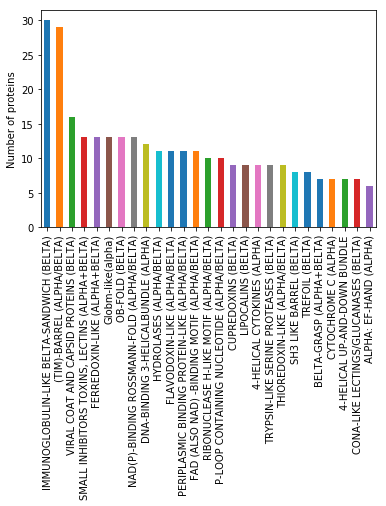

In [16]:
# Frequency of folds
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
freq_plot = dd_dataset['Fold'].value_counts().plot(ax=ax, kind='bar')
freq_plot.set_ylabel('Number of proteins')
plt.show()

## SVM classifier

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Hyperparameters
kernel = 'rbf'

# An instance of SVM classifier
svm_cl = SVC(kernel=kernel)

Define range of parameters for Grid Search

In [9]:
# Penalty parameter
c_range = {'C': [float(2**i) for i in range(-14, 14)]}
# Gamma parameter for RBF kernel
gamma_range = {'gamma': [float(2**i) for i in range(-14, 14)]} if kernel == 'rbf' else {}

param_range = {**c_range, **gamma_range}

# Arguments for grid search
cv_fold = 5
n_workers = -1 # Number of CPU threads

result = GridSearchCV(svm_cl, param_range, cv=cv_fold, n_jobs=n_workers, refit=True,
                      verbose=1)

Start grid search!

In [10]:
result.fit(train_data, labels)

Fitting 5 folds for each of 784 candidates, totalling 3920 fits


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1545 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3545 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3913 out of 3920 | elapsed:  1.7min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3920 out of 3920 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0], 'gamma': [6.103515625e-05, 0.0...25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best results

In [11]:
print("Best accuracy: %.2f" % (result.best_score_ * 100))

Best accuracy: 29.26


Confusion matrix

Accuracy:  73.31189710610933


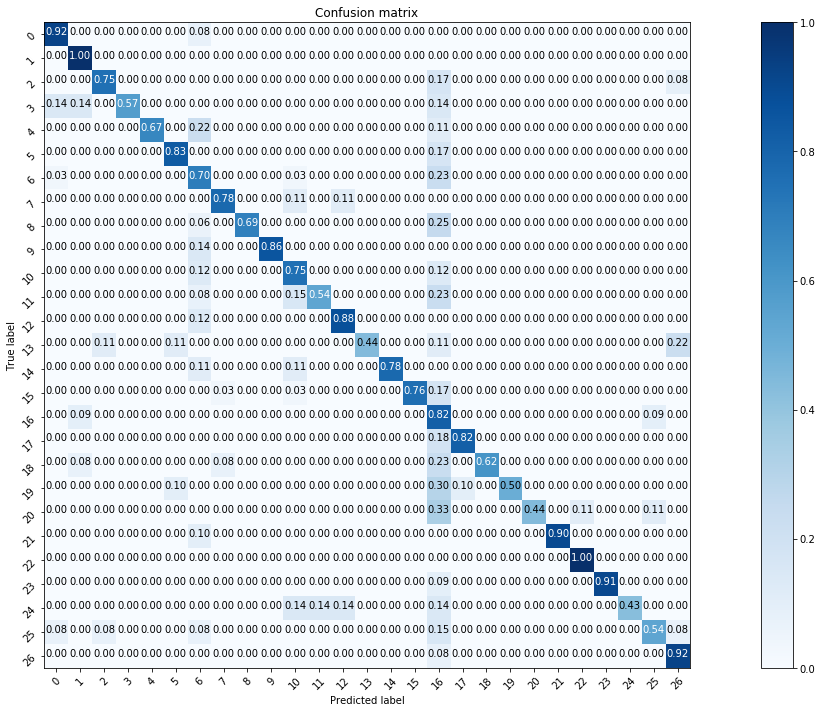

In [17]:
from misc import plt_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

y_pred = result.best_estimator_.predict(train_data)
cm = confusion_matrix(labels, y_pred)

print("Accuracy: ", (accuracy_score(labels, y_pred) * 100))

plt.figure(figsize=(20, 10))
plt_confusion_matrix(cm, np.unique(labels))


Classification report

In [18]:
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86        13
          1       0.70      1.00      0.82         7
          2       0.82      0.75      0.78        12
          3       1.00      0.57      0.73         7
          4       1.00      0.67      0.80         9
          5       0.71      0.83      0.77         6
          6       0.66      0.70      0.68        30
          7       0.78      0.78      0.78         9
          8       1.00      0.69      0.81        16
          9       1.00      0.86      0.92         7
         10       0.46      0.75      0.57         8
         11       0.88      0.54      0.67        13
         12       0.78      0.88      0.82         8
         13       1.00      0.44      0.62         9
         14       1.00      0.78      0.88         9
         15       1.00      0.76      0.86        29
         16       0.18      0.82      0.29        11
         17       0.90      0.82      0.86   

# XG Boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Create Dmatrix for more performance 
data_matrix = xgb.DMatrix(data=train_data,label=labels)

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.2, random_state=123)

In [ ]:
# Instantitate an XGBosst Classifier
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.1, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)


In [ ]:
# Fit the classifier to the training set
xg_clf.fit(X_train,y_train)

# Predit test data
preds = xg_clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, preds)

In [ ]:
print("Best accuracy: %.2f" % (accuracy*100))
